In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

from emely import PoissonMLE

In [30]:
# define plot style
violet = "#785ef0"
blue = "#648fff"
yellow = "#ffb000"
orange = "#fe6100"
red = "#dc267f"
black = "000000"
gray = "cccccc"
white = "ffffff"

plt.style.use("seaborn-v0_8")

### Overview

This notebook performs tests to validate the predicted value and covariance of the dependent variable $y_\mathrm{data}$ obtained when fitting a Lorentzian model with **Poisson noise** _without providing initial parameters_.

### Model and noise

We estimate the parameters $\theta = (a, \omega_0, \gamma)$ of a Lorentzian curve:

$
f(\omega, \theta) = \frac{a}{\sqrt{(\omega^2 - \omega_0^2)^2 + \gamma^2 \omega^2}}
$,

from noisy measurements

$
y(\omega) = f(\omega, \theta) + \varepsilon
$,

where the noise term $ \varepsilon $ follows **Poisson statistics**. 

### Physical Context

In this physical setting, the function $f(\omega, \theta)$ represents the oscillation amplitude $y(\omega)$ of a driven, damped harmonic oscillator. The parameter $a$ corresponds to the ratio of the driving force to the mass,

$
a = \frac{F_0}{m},
$

so the Lorentzian model directly describes the absolute deflection amplitude as a function of frequency.


In [31]:
# define the model to fit
def lorentzian(omega, a, omega_0, gamma):
    return a / np.sqrt((omega**2 - omega_0**2) ** 2 + gamma**2 * omega**2)

In [32]:
# define model parameters
domega = 0.2  # (rad)
omega_0 = 10  # (rad)
gamma = 2  # (rad)
a = 200  # (m/s^2)
p = (a, omega_0, gamma)

# define model variables
omega_rng = (omega_0 - 3 * gamma, omega_0 + 3 * gamma)
n_omega = round((omega_rng[1] - omega_rng[0]) / domega) + 1
omega = omega_rng[0] + domega * np.arange(n_omega)

# set the random seed
np.random.seed(0)

In [33]:
# create the measurement
f_omega = lorentzian(omega, *p)
y_omega = poisson.rvs(f_omega)

# define initial guesses and bounds
params_init = None
param_bounds = (
    [0, 0, 0],
    [1000, 100, 10],
)

# initialize the estimator
estimator = PoissonMLE(lorentzian, verbose=True)

# fit the model
params, params_cov = estimator.fit(
    omega,
    y_omega,
    params_init=params_init,
    param_bounds=param_bounds,
)

# predict the dependent variable
y_pred, y_cov = estimator.predict(omega)
y_err = np.sqrt(np.diag(y_cov))

Estimating initial parameters...
Initial parameters: [199.14811509   9.96053058   1.86006236]
Success: True
Iterations: 55
Function calls: 2520
Message: Optimization terminated successfully.
--------------------------------
Estimating optimal parameters...
Optimal parameters: [199.14888273   9.96053477   1.86005637]
Success: True
Iterations: 114
Function calls: 236
Message: Optimization terminated successfully.
--------------------------------


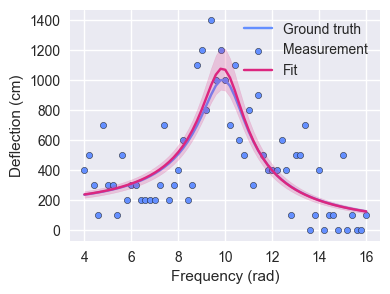

In [34]:
# show the measurement and the fit
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(omega, 1e2 * f_omega, label="Ground truth", color=blue, zorder=10)
ax.scatter(
    omega,
    1e2 * y_omega,
    label="Measurement",
    s=20,
    facecolor=blue,
    edgecolor=black,
    zorder=5,
)
ax.plot(omega, 1e2 * y_pred, label="Fit", color=red, zorder=20)
ax.fill_between(
    omega, 1e2 * (y_pred - y_err), 1e2 * (y_pred + y_err), color=red + "33", zorder=15
)

ax.set_xlabel("Frequency (rad)")
ax.set_ylabel("Deflection (cm)")
ax.legend()